<a href="https://colab.research.google.com/github/HackerJacky/TimeSeriesColab/blob/main/TS_HW8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tidyfinance --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 54.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 MB 19.6 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 18.1.0
    Uninstalling pyarrow-18.1.0:
      Successfully uninstalled pyarrow-18.1.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 25.2.1 requires pyarrow<20.0.0a0,>=14.0.0; platform_machine == "x86_64", but you have pyarrow 20.0.0 which is incompatible.
pylibcudf-cu12 25.2.1 requires pyarrow<20.0.0a0,>=14.0.0; platform_machine == "x86_64", but you have pyarrow 20.0.0 which is incompatible.


In [9]:
pip install regtabletotext

In [36]:
import pandas as pd
import numpy as np
import sqlite3
import statsmodels.api as sm
from plotnine import *
from mizani.formatters import percent_format
from regtabletotext import prettify_result
import tidyfinance as tf
import matplotlib.pyplot as plt
from plotnine import *
from scipy.stats import ttest_rel

#In this chapter, we continue with portfolio sorts in a univariate setting. Yet, we consider firm size as a sorting variable, which gives rise to a well-known return factor: the size premium.


In [4]:
crsp_monthly=pd.read_csv('/content/us_stock_monthly.csv')

In [5]:
crsp_monthly.head()

,Unnamed: 0,permno,date,ret,shrout,altprc,primaryexch,siccd
0,0,10117,1986-10-01,-0.141304,29462000.0,1.234375,Q,7390.0
1,1,10117,1986-11-01,-0.050633,29462000.0,1.171875,Q,7390.0
2,2,10117,1986-12-01,-0.200000,30696000.0,0.937500,Q,7390.0
3,3,10117,1987-01-01,0.066667,30696000.0,1.000000,Q,7390.0
4,4,10117,1987-02-01,0.375000,30696000.0,1.375000,Q,7390.0


###The first additional variable we create is market capitalization (mktcap), which is the product of the number of outstanding shares (shrout) and the last traded price in a month (prc). Note that in contrast to returns (ret), these two variables are not adjusted ex-post for any corporate actions like stock splits.**粗體文字**

In [6]:
#mktcap(new market value variable)=shrout(Shares Outstanding)*altprc(The latest stock prices this month)
crsp_monthly = (crsp_monthly
  .assign(mktcap=lambda x: x["shrout"]*x["altprc"]/1000000)
  .assign(mktcap=lambda x: x["mktcap"].replace(0, np.nan))
)

In [12]:
invalid_dates = crsp_monthly[~crsp_monthly["date"].str.match(r"\d{4}-\d{2}-\d{2}", na=False)]
print(invalid_dates["date"])

2902728    2002-
Name: date, dtype: object


In [21]:
crsp_monthly = crsp_monthly.dropna(subset=["date"])

In [20]:
crsp_monthly["date"] = pd.to_datetime(crsp_monthly["date"], errors='coerce')


In [22]:
crsp_monthly["date"] = pd.to_datetime(crsp_monthly["date"])

<ipython-input-22-3516751915>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [23]:
#create market value lag
#Creates a time offset that adds one month to a given datetime value
mktcap_lag = (crsp_monthly
  .assign(
    date=lambda x: x["date"] + pd.DateOffset(months=1),
    mktcap_lag=lambda x: x["mktcap"]
  )
  .get(["permno", "date", "mktcap_lag"])
)
#Before merging,we need to clean the columns.
crsp_monthly = crsp_monthly.drop(columns=["mktcap_lag"], errors="ignore")

#merge to the original database
crsp_monthly = (crsp_monthly
  .merge(mktcap_lag, how="left", on=["permno", "date"])
)



###Lagged market capitalization is typically used to compute value-weighted portfolio returns.

In [24]:
crsp_monthly.head()

,Unnamed: 0,permno,date,ret,shrout,altprc,primaryexch,siccd,mktcap,mktcap_lag
0,0,10117,1986-10-01,-0.141304,29462000.0,1.234375,Q,7390.0,36.367156,42.351625
1,1,10117,1986-11-01,-0.050633,29462000.0,1.171875,Q,7390.0,34.525781,36.367156
2,2,10117,1986-12-01,-0.200000,30696000.0,0.937500,Q,7390.0,28.777500,34.525781
3,3,10117,1987-01-01,0.066667,30696000.0,1.000000,Q,7390.0,30.696000,28.777500
4,4,10117,1987-02-01,0.375000,30696000.0,1.375000,Q,7390.0,42.207000,30.696000


In [39]:
# Label the top 20% and bottom 20% of firms by market capitalization for each month.
crsp_with_quantiles = (
    crsp_monthly
    .groupby("date")
    .apply(lambda x: x.assign(
        top20=(x["mktcap"] >= x["mktcap"].quantile(0.80)),
        bottom20=(x["mktcap"] <= x["mktcap"].quantile(0.20))
    ))
    .reset_index(drop=True)
)
# calculate average return
top20_ret = (
    crsp_with_quantiles[crsp_with_quantiles["top20"]]
    .groupby("date")["ret"]
    .mean()
    .rename("Top20_AvgRet")
)

bottom20_ret = (
    crsp_with_quantiles[crsp_with_quantiles["bottom20"]]
    .groupby("date")["ret"]
    .mean()
    .rename("Bottom20_AvgRet")
)

avg_returns = pd.concat([top20_ret, bottom20_ret], axis=1)
print(avg_returns.head())


<ipython-input-39-562579148>:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.


            Top20_AvgRet  Bottom20_AvgRet
date                                     
1960-01-01     -0.056014        -0.006899
1960-02-01      0.016313        -0.014554
1960-03-01     -0.009159        -0.033869
1960-04-01     -0.005776        -0.035843
1960-05-01      0.045927        -0.006023


In [37]:
mask = avg_returns.notna().all(axis=1)
t_stat, p_val = ttest_rel(
    avg_returns.loc[mask, "Top20_AvgRet"],
    avg_returns.loc[mask, "Bottom20_AvgRet"]
)

print(f"T-stat: {t_stat:.3f}, P-value: {p_val:.3f}")




T-stat: 12.462, P-value: 0.000


###Based on the paired t-test, the difference in average monthly returns between the top 20% and bottom 20% of firms ranked by market capitalization is statistically significant (t = 12.462, p < 0.001).

###This result suggests that, over the observed period, firms in the top 20% consistently earned higher average returns than those in the bottom 20%, and the observed difference is unlikely due to random chance.

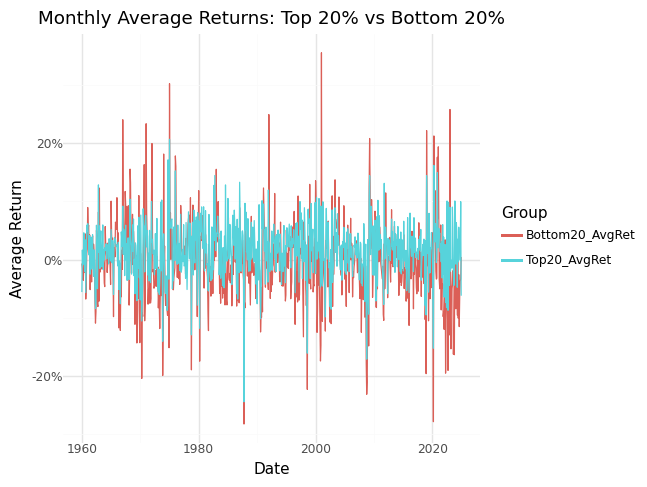

In [38]:
avg_returns_long = (
    avg_returns
    .reset_index()
    .melt(id_vars="date", var_name="Group", value_name="Return")
)

ret_comparison_plot = (
    ggplot(avg_returns_long, aes(x="date", y="Return", color="Group"))
    + geom_line()
    + labs(
        title="Monthly Average Returns: Top 20% vs Bottom 20%",
        x="Date", y="Average Return"
    )
    + scale_y_continuous(labels=percent_format())
    + scale_x_date(date_labels="%Y")
    + theme_minimal()
)

ret_comparison_plot.draw()
